# Pre Test set

x is 224 and y is 224 and z is 11
(50176, 11)


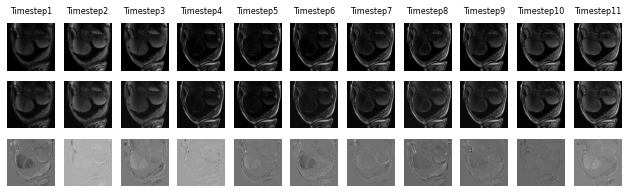

In [1]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from hyperspy.learn.rpca import rpca_godec, orpca
path = 'data/MOLLI_pre_dataset/test/0387056_20140423_MOLLI_3.npy'
vols = np.load(path).transpose(1, 2, 0)
x, y, z = vols.shape
print(f"x is {x} and y is {y} and z is {z}")
M = vols.reshape(x*y, z)
print(M.shape)
low, sparse, U, S, V = rpca_godec(M, rank=5)
low_matrix = low.reshape((x, y, z))
sparse_matrix = sparse.reshape((x, y, z))

fig = plt.figure(figsize=(11, 3))
title_font_size=8
title_pad = 10
for i in range(z):
    ax1 = fig.add_subplot(3, 11, 1+i)
    plt.imshow(vols[..., i], cmap='gray')
    plt.axis('off')
    ax1.set_title(f"Timestep{i+1}", fontsize=title_font_size, pad=title_pad)

    ax2 = fig.add_subplot(3, 11, 12+i)
    plt.imshow(low_matrix[..., i], cmap='gray')
    plt.axis('off')

    ax3 = fig.add_subplot(3, 11, 23+i)
    plt.imshow(sparse_matrix[..., i], cmap='gray')
    plt.axis('off')

## Test Metrics

### Original volume

#### First Eigen Component percentage

In [2]:
from scripts.utils import *
orig_path = 'data/MOLLI_pre_dataset/test'
orig_pca_changes = []
for file in sorted(glob.glob(os.path.join(orig_path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    orig_pca_changes.append(org_dis)
print(f"Mean of original PCA is {np.mean(np.array(orig_pca_changes))}")

Mean of original PCA is 0.7867720274668718


#### T1 fitting

Mean of t1err is 11.072921129848977 and std is 4.963850319538608
Mean of t1err is 14.217012343355398 and std is 7.345939012337131


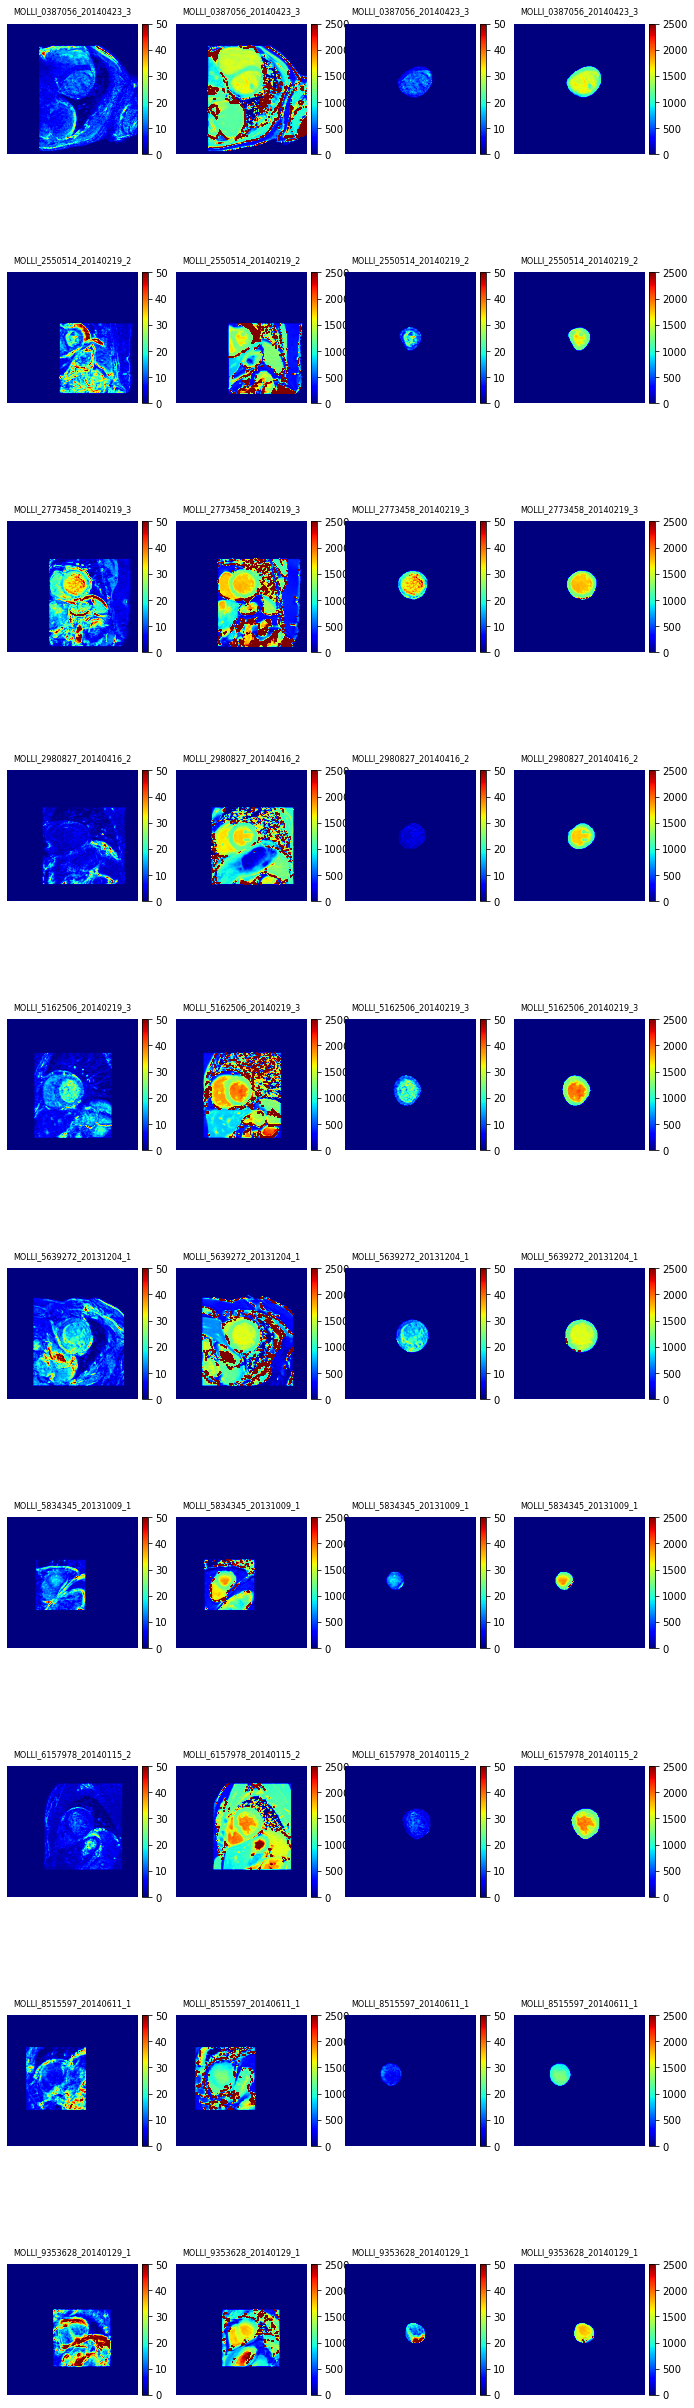

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
path = "data/MOLLI_pre_dataset/T1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
orig_t1err_square_list = []
orig_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    orig_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    orig_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(orig_t1err_square_list))} and std is {np.std(np.array(orig_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(orig_t1err_heart_list))} and std is {np.std(np.array(orig_t1err_heart_list))}")
plt.savefig(f"data/MOLLI_pre_dataset/T1_SDerr/orig_t1err.png", dpi=300)

### Round 1

In [4]:
import voxelmorph_group as vxm  # nopep8
import numpy as np
import glob
import os
jacobian = vxm.losses.Jacobian().loss

In [10]:
r = 1
root = f"results/MOLLI_pre/group/rank_5_5_3/ncc/smooth/image_loss_weight1/cycle_loss_weight0.01/weight0.001/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre"
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [6]:
path = f"{base_path}/moved"
r1_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r1_pca_changes.append(org_dis)
print(f"Mean of Round 1 PCA is {np.mean(np.array(r1_pca_changes))} and std is {np.std(np.array(r1_pca_changes))}")

Mean of Round 1 PCA is 0.7927752300253198 and std is 0.024466920531528248


#### Jacobian Determination

In [7]:
r1_folding_ratio_list = []
r1_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r1_folding_ratio_list.append(folding_ratio)
    r1_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r1_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r1_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.003245266620069742


#### T1 fitting

Mean of t1err is 10.437374324877956 and std is 4.602035124946241
Mean of t1err is 13.791152238496874 and std is 7.143448986455796


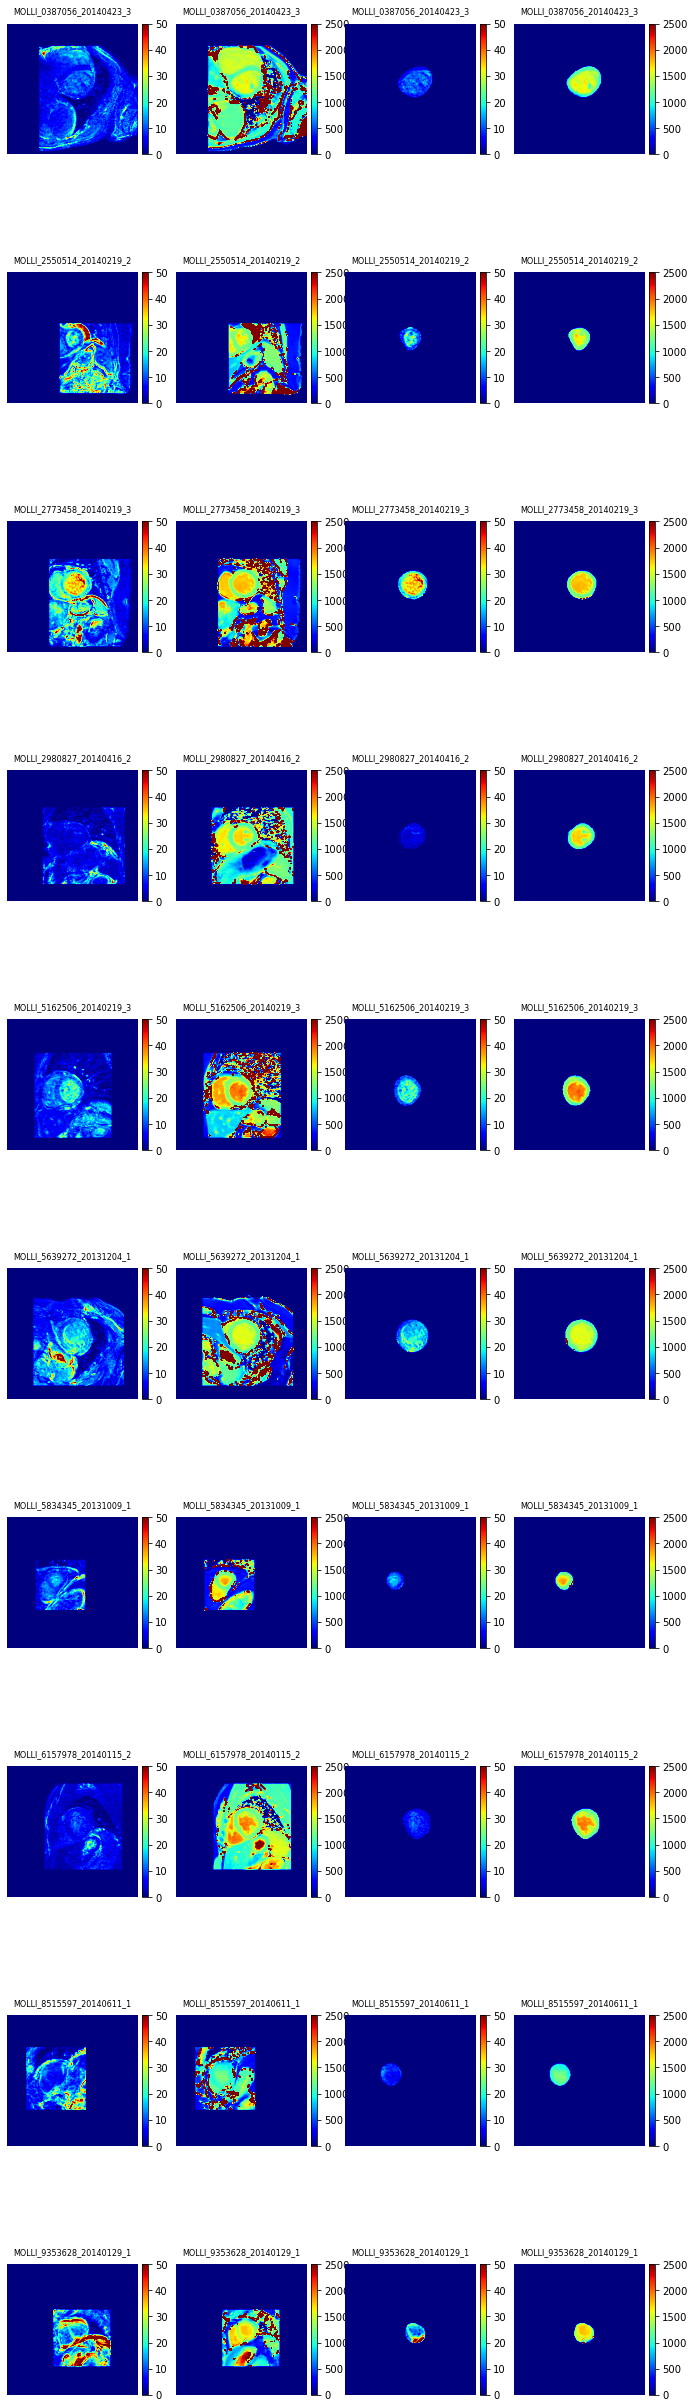

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
path = f"{base_path}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r1_t1err_square_list = []
r1_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    r1_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    r1_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r1_t1err_square_list))} and std is {np.std(np.array(r1_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r1_t1err_heart_list))} and std is {np.std(np.array(r1_t1err_heart_list))}")
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

### Round 2

In [11]:
r = 2
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [13]:
path = f"{base_path}/moved"
r2_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r2_pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(r2_pca_changes))} and std is {np.std(np.array(r2_pca_changes))}")

Mean of Round 2 PCA is 0.7955178494407475 and std is 0.023789433252245046


#### Jacobian Determination

In [14]:
r2_folding_ratio_list = []
r2_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r2_folding_ratio_list.append(folding_ratio)
    r2_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r2_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r2_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.001954613719135523


#### T1 fitting

Mean of t1err is 10.122951880380148 and std is 4.451921202037855
Mean of t1err is 13.634132334212584 and std is 7.129745918124645


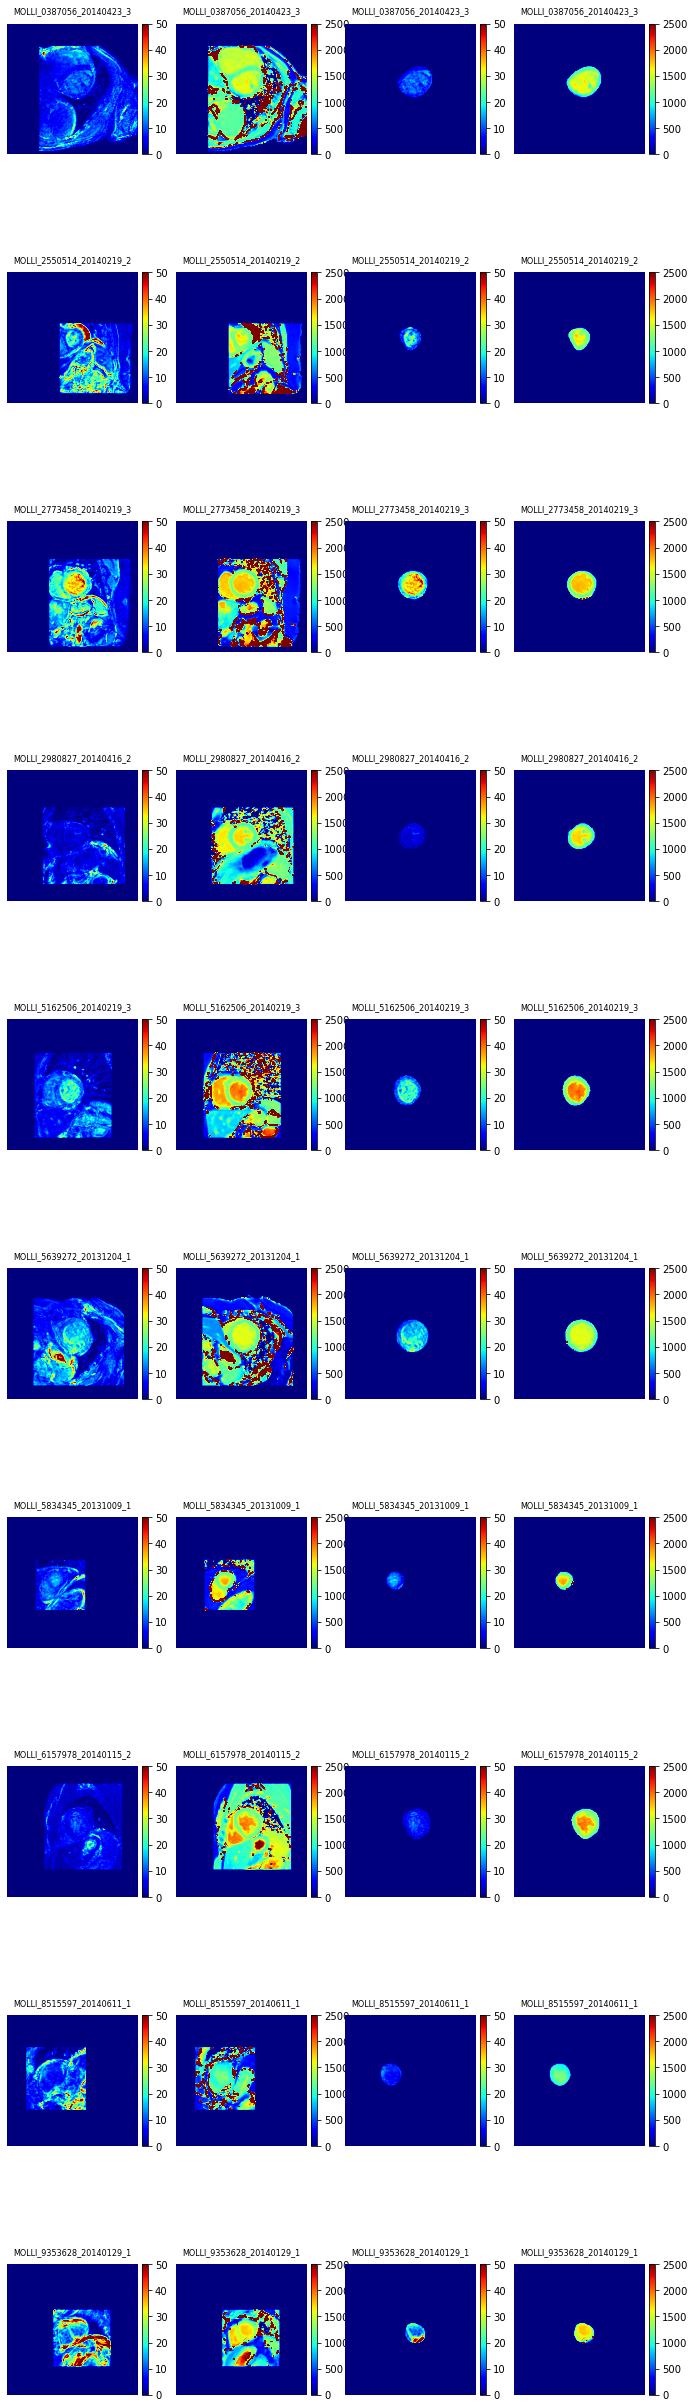

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
path = f"{base_path}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r2_t1err_square_list = []
r2_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    r2_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    r2_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r2_t1err_square_list))} and std is {np.std(np.array(r2_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r2_t1err_heart_list))} and std is {np.std(np.array(r2_t1err_heart_list))}")
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

### Round 3

In [17]:
r = 3
base_path = f"{root}/round{r}"

#### First Eigen Component percentage

In [18]:
path = f"{base_path}/moved"
r3_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r3_pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(r3_pca_changes))} and std is {np.std(np.array(r3_pca_changes))}")

Mean of Round 2 PCA is 0.7979003486749671 and std is 0.023960652774769827


#### Jacobian Determination

In [19]:
r3_folding_ratio_list = []
r3_mag_det_jac_det_list = []
path = f"{base_path}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r3_folding_ratio_list.append(folding_ratio)
    r3_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r3_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r3_mag_det_jac_det_list))}")

Mean of folding ratio is 0.0
Mean of mag det jac det is 0.0025424370542168617


#### T1 fitting

Mean of t1err is 10.02856480541109 and std is 4.358976308407885
Mean of t1err is 13.556822511547058 and std is 7.077593979703572


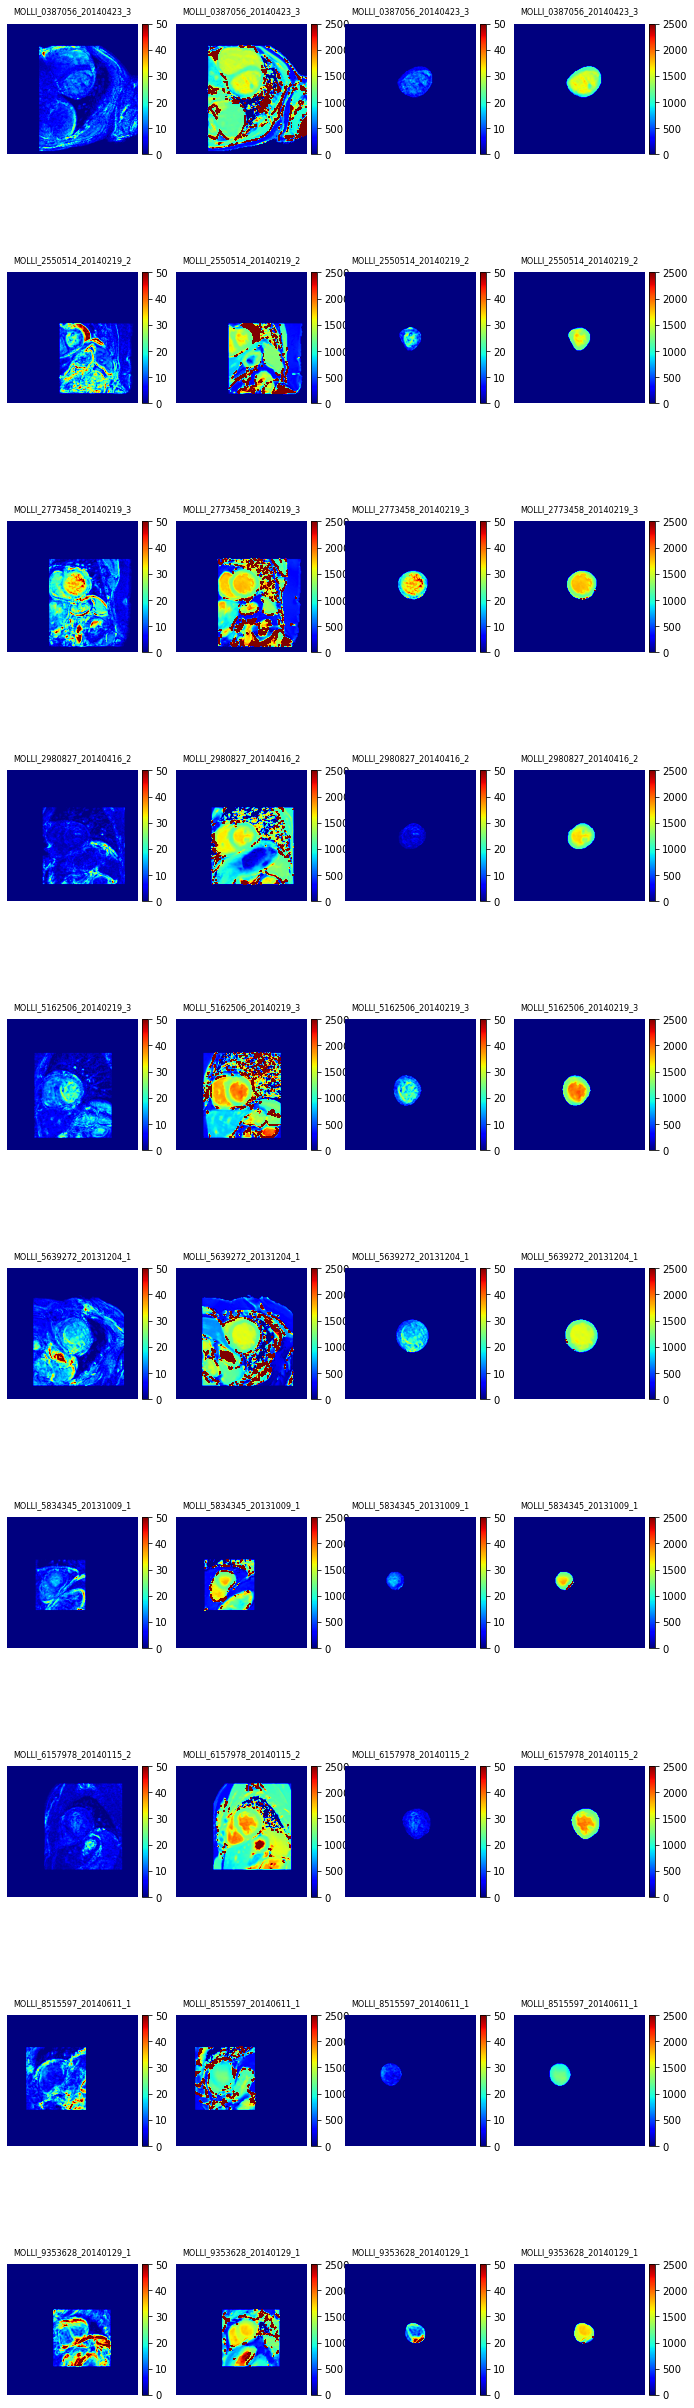

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget

path = f"{base_path}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r3_t1err_square_list = []
r3_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    r3_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    r3_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r3_t1err_square_list))} and std is {np.std(np.array(r3_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r3_t1err_heart_list))} and std is {np.std(np.array(r3_t1err_heart_list))}")
plt.savefig(f"{base_path}/t1_SDerr.png", dpi=300)

### Summary

In [22]:
import pandas as pd
df = pd.DataFrame()
df['Cases'] = subject_list
df['Raw Square T1err'] = orig_t1err_square_list
df['R1 Square T1err'] = r1_t1err_square_list
df['R2 Square T1err'] = r2_t1err_square_list
df['R3 Square T1err'] = r3_t1err_square_list
df['Square T1err diff'] = (df['Raw Square T1err'] - df['R3 Square T1err']) / df['Raw Square T1err']
df['Raw Heart T1err'] = orig_t1err_heart_list
df['R1 Heart T1err'] = r1_t1err_heart_list
df['R2 Heart T1err'] = r2_t1err_heart_list
df['R3 Heart T1err'] = r3_t1err_heart_list
df['Heart T1err diff'] = (df['Raw Heart T1err'] - df['R3 Heart T1err']) / df['Raw Heart T1err']
df

,Cases,Raw Square T1err,R1 Square T1err,R2 Square T1err,R3 Square T1err,Square T1err diff,Raw Heart T1err,R1 Heart T1err,R2 Heart T1err,R3 Heart T1err,Heart T1err diff
0,MOLLI_0387056_20140423_3,7.539072,7.142355,7.055880,7.011761,0.069944,9.731935,9.591887,9.405148,9.321459,0.042178
1,MOLLI_2550514_20140219_2,12.360840,12.228374,11.988316,11.839314,0.042192,14.576425,14.639302,14.525060,14.531647,0.003072
2,MOLLI_2773458_20140219_3,13.635501,13.076499,12.522697,12.490565,0.083967,28.671655,28.381935,28.226149,28.223572,0.015628
3,MOLLI_2980827_20140416_2,5.785524,5.516461,5.302522,5.247108,0.093063,3.958349,4.102054,3.928125,4.075059,-0.029484
4,MOLLI_5162506_20140219_3,8.644283,8.110950,7.903437,7.862499,0.090439,17.141349,16.369687,16.360423,16.249316,0.052040
5,MOLLI_5639272_20131204_1,11.297461,10.607869,10.334603,10.252742,0.092474,17.010539,16.485905,16.366350,16.166065,0.049644
6,MOLLI_5834345_20131009_1,10.555566,9.341180,8.962093,8.975131,0.149725,12.637421,11.341122,11.039940,10.858829,0.140740
7,MOLLI_6157978_20140115_2,5.011841,4.822800,4.662816,4.651940,0.071810,6.933013,6.720551,6.570524,6.513927,0.060448
8,MOLLI_8515597_20140611_1,12.463286,11.847697,11.498003,11.331416,0.090816,7.736930,7.668832,7.628897,7.640742,0.012432
9,MOLLI_9353628_20140129_1,23.435838,21.679557,20.999151,20.623173,0.120016,23.772507,22.610249,22.290706,21.987610,0.075082


In [23]:
df.describe()

,Raw Square T1err,R1 Square T1err,R2 Square T1err,R3 Square T1err,Square T1err diff,Raw Heart T1err,R1 Heart T1err,R2 Heart T1err,R3 Heart T1err,Heart T1err diff
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,11.072921,10.437374,10.122952,10.028565,0.090445,14.217012,13.791152,13.634132,13.556823,0.042178
std,5.232358,4.850971,4.692737,4.594764,0.028940,7.743300,7.529856,7.515412,7.460439,0.046593
min,5.011841,4.822800,4.662816,4.651940,0.042192,3.958349,4.102054,3.928125,4.075059,-0.029484
25%,7.815375,7.384504,7.267769,7.224446,0.074849,8.235682,8.149595,8.072960,8.060921,0.013231
50%,10.926513,9.974525,9.648348,9.613936,0.090628,13.606923,12.990212,12.782500,12.695238,0.045911
75%,12.437674,12.133205,11.865737,11.712339,0.092915,17.108646,16.456851,16.364868,16.228503,0.058346
max,23.435838,21.679557,20.999151,20.623173,0.149725,28.671655,28.381935,28.226149,28.223572,0.140740


In [24]:
df_2 = pd.DataFrame()
df_2['Cases'] = subject_list
df_2['Raw PCA'] = orig_pca_changes
df_2['R1 PCA'] = r1_pca_changes
df_2['R2 PCA'] = r2_pca_changes
df_2['R3 PCA'] = r3_pca_changes
df_2['R1 Det'] = r1_mag_det_jac_det_list
df_2['R2 Det'] = r2_mag_det_jac_det_list
df_2['R3 Det'] = r3_mag_det_jac_det_list
df_2['R1 Fold ratio'] = r1_folding_ratio_list
df_2['R2 Fold ratio'] = r2_folding_ratio_list
df_2['R3 Fold ratio'] = r3_folding_ratio_list
df_2

,Cases,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
0,MOLLI_0387056_20140423_3,0.806249,0.813100,0.816546,0.817269,0.002076,0.001557,0.001317,0.0,0.0,0.0
1,MOLLI_2550514_20140219_2,0.792254,0.799281,0.801097,0.803518,0.003610,0.001956,0.002684,0.0,0.0,0.0
2,MOLLI_2773458_20140219_3,0.773361,0.778967,0.781555,0.783811,0.003591,0.002063,0.002606,0.0,0.0,0.0
3,MOLLI_2980827_20140416_2,0.813012,0.818160,0.820242,0.823712,0.003369,0.001944,0.002957,0.0,0.0,0.0
4,MOLLI_5162506_20140219_3,0.787799,0.791800,0.793713,0.795680,0.003437,0.001969,0.002563,0.0,0.0,0.0
5,MOLLI_5639272_20131204_1,0.773060,0.777355,0.780891,0.783144,0.002945,0.001962,0.002562,0.0,0.0,0.0
6,MOLLI_5834345_20131009_1,0.757565,0.765012,0.768903,0.771658,0.003399,0.002068,0.002716,0.0,0.0,0.0
7,MOLLI_6157978_20140115_2,0.839774,0.843348,0.844484,0.847740,0.003210,0.001731,0.002688,0.0,0.0,0.0
8,MOLLI_8515597_20140611_1,0.770515,0.778245,0.781606,0.784470,0.003377,0.002249,0.002941,0.0,0.0,0.0
9,MOLLI_9353628_20140129_1,0.754133,0.762484,0.766141,0.768001,0.003440,0.002048,0.002390,0.0,0.0,0.0


In [25]:
df_2.describe()

,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0
mean,0.786772,0.792775,0.795518,0.797900,0.003245,0.001955,0.002542,0.0,0.0,0.0
std,0.026789,0.025790,0.025076,0.025257,0.000452,0.000191,0.000463,0.0,0.0,0.0
min,0.754133,0.762484,0.766141,0.768001,0.002076,0.001557,0.001317,0.0,0.0,0.0
25%,0.771151,0.777578,0.781057,0.783311,0.003250,0.001947,0.002562,0.0,0.0,0.0
50%,0.780580,0.785384,0.787659,0.790075,0.003388,0.001965,0.002645,0.0,0.0,0.0
75%,0.802750,0.809645,0.812684,0.813831,0.003439,0.002059,0.002709,0.0,0.0,0.0
max,0.839774,0.843348,0.844484,0.847740,0.003610,0.002249,0.002957,0.0,0.0,0.0


In [ ]:
df_2.describe()

,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.0,10.0
mean,0.786772,0.792775,0.795518,0.797900,0.003245,0.001955,0.002542,0.0,0.0,0.0
std,0.026789,0.025790,0.025076,0.025257,0.000452,0.000191,0.000463,0.0,0.0,0.0
min,0.754133,0.762484,0.766141,0.768001,0.002076,0.001557,0.001317,0.0,0.0,0.0
25%,0.771151,0.777578,0.781057,0.783311,0.003250,0.001947,0.002562,0.0,0.0,0.0
50%,0.780580,0.785384,0.787659,0.790075,0.003388,0.001965,0.002645,0.0,0.0,0.0
75%,0.802750,0.809645,0.812684,0.813831,0.003439,0.002059,0.002709,0.0,0.0,0.0
max,0.839774,0.843348,0.844484,0.847740,0.003610,0.002249,0.002957,0.0,0.0,0.0
